## Setup

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0   117M      0  0:00:06  0:00:06 --:--:--  102M


In [ ]:
!unzip -q kagglecatsanddogs_5340.zip
!ls

 CDLA-Permissive-2.0.pdf      PetImages        sample_data
 kagglecatsanddogs_5340.zip  'readme[1].txt'


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!ls PetImages

Cat  Dog


In [ ]:
import os

num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 1590 images


In [ ]:
image_size = (180, 180)
batch_size = 128

train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Using 4682 files for validation.


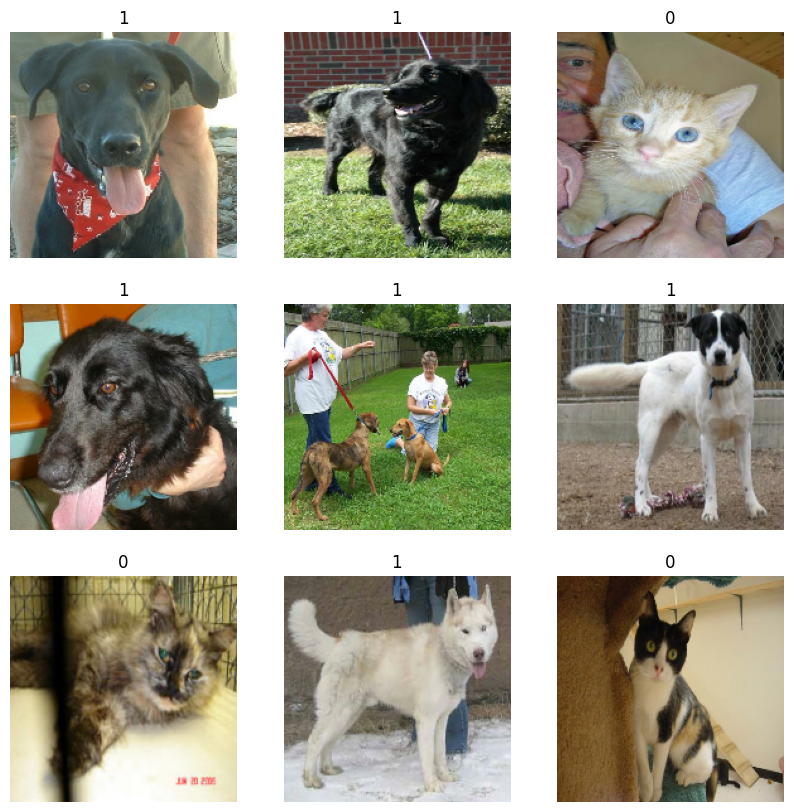

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

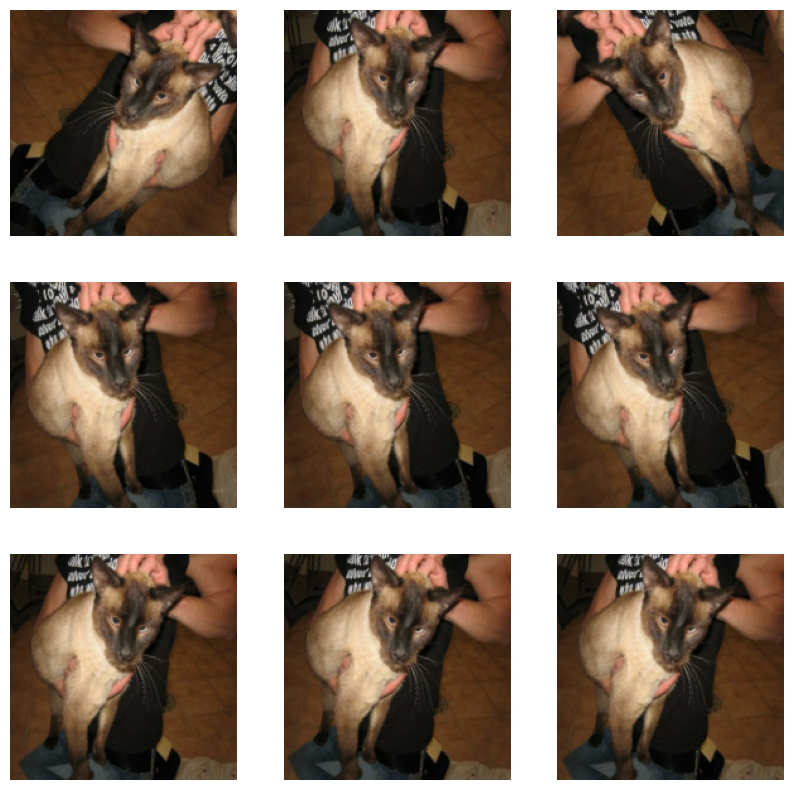

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [ ]:
# Apply `data_augmentation` to the training images.
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf.data.AUTOTUNE,
)
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

In [ ]:
model=tf.keras.models.Sequential([
    keras.layers.Conv2D(32,(3,3),input_shape=(180,180,3),activation='relu'),
    keras.layers.MaxPooling2D(2,2),
    keras.layers.Conv2D(64,(3,3),activation="relu"),
    keras.layers.MaxPooling2D(2,2),
    keras.layers.Conv2D(128,(3,3),activation='relu'),
    keras.layers.MaxPooling2D(2,2),
    keras.layers.Conv2D(128,(3,3),activation='relu'),
    keras.layers.MaxPooling2D(2,2),

    keras.layers.Flatten(),
    keras.layers.Dense(512,activation='relu'),
    keras.layers.Dense(1,activation='sigmoid')
])

In [ ]:
epochs = 25

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/25
147/147 [==============================] - 113s 663ms/step - loss: 4.8267 - accuracy: 0.5685 - val_loss: 0.6576 - val_accuracy: 0.6277
Epoch 2/25
 49/147 [=========>....................] - ETA: 1:03 - loss: 0.6435 - accuracy: 0.6339

In [ ]:
img = keras.utils.load_img(
    "PetImages/Cat/6779.jpg", target_size=image_size
)
img_array = keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = float(predictions[0])
print(f"This image is {100 * (1 - score):.2f}% cat and {100 * score:.2f}% dog.")